In [41]:
import pymysql.cursors
import os
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

conn = mysql.connector.connect(
        host="localhost",
        user="root",
        password="")
cur = conn.cursor()
cur.execute ("""USE orders;""")

def GetTicker ():
    print ('Сейчас Вам будет предложено ввести данные для заполнения книги заявок')
    correct = 0
    while correct == 0:
        seccode = input ('Введите тикер: ')
        cur.execute("SELECT count(*) FROM security_type WHERE (seccode = '"+ seccode +"');")
        if cur.fetchall() != [(0,)]:
            correct = 1
        else:
            print ('Вы ввели некорректный тикер. Повторите ввод')
    return(seccode)

def GetTime():
    correct = 0
    while correct == 0:
        moment = int(input ('Введите момент времени (момент времени должен быть записан в формате HHMMSSQQQ): '))
        if int(moment) in range(100000000,235959999):
            correct = 1
        else:
            print ('Вы ввели некорректный момент времени. Повторите ввод')
    return(moment)

def DefineTable(seccode):
    cur.execute("SELECT instrument_type FROM security_type WHERE (seccode = '%s');" %(ticker))
    if cur.fetchall() == [('ordinary share',)]:
        table = 'ordshares'
    else:
        cur.execute("SELECT instrument_type FROM security_type WHERE (seccode = '%s');" % (ticker))
        if cur.fetchall() == [('preffered share',)]:
            table = 'prefshares'
        else:
            table = 'bonds'
    return(table)

def ReverseToDatetime(date, ordertime):
    hh24 = ordertime//10000000 # выделяем разряды, соответствующие часам
    mi = ordertime//100000%100 # выделяем разряды, соответствующие минутам
    ss = ordertime//1000%100 # выделяем разряды, соответствующие секундам
    ff3 = ordertime%1000 # выделяем разряды, соответствующие микросекундам
    reversed_time = datetime.strptime(date + ' ' + str(hh24) + ':' + str(mi) + ':' + str(ss) + ',' + str(ff3), '%d.%m.%Y %H:%M:%S,%f') #переводим строку в формат времени для python
    return(reversed_time)

# wait_list [wait] (0 - buysell, 1 - ordertime, 2 - orderno, 3 - price, 4 - volume, 5 - время исполнения, 6 - время отмены, 7 - состояние)
# rows [elem] (0 - id, 1 - seccode, 2 - buysell, 3 - ordertime, 4 - orderno, 5 - action, 6 - price, 7 - volume, 8 - tradeno, 9 - tradeprice)
def UpdateWaitList (elem, wait_list):
        date = '01.09.2015'
        # отбор нерыночных заявок
        if elem[6] != 0:
            # если action = 1 (выставление заявки), то добавляем такую заявку в очередь
            if elem[5] == '1':
                wait_list.append([elem[2], ReverseToDatetime(date, elem[3]), elem[4], elem[6], elem[7], ReverseToDatetime(date, 0), ReverseToDatetime(date, 0),'wait'])
            # если action = 0 (отмена заявки), то ищем эту заявку в очереди и удаляем объем заявки
            elif elem[5] == '0':
                for wait in wait_list:
                    if elem[4] == wait[2]:
                        wait[4] = 0 # обнуляем объем
                        wait[7] = 'cancelled'# меняем признак заявки в очереди
                        wait[6] = ReverseToDatetime(date, elem[3]) # указываем время отмены заявки
                        break
            # если action = 2 (исполнение), то ищем эту заявку и проверяем, как она исполнилась
            elif elem[5] == '2':
                for wait in wait_list:
                    if elem[4] == wait[2]:
                        wait[4] -= elem [7]
                        # если после исполнения заявки образовался отрицательный объем, записываем заявку в список заявок айсбергов, удаляем ее из из очереди заявок
                        if wait[4] < 0:
                            wait[4] = 0 # обнуляем объем, чтобы в стакане не было отрицательных объемов
                            wait[7] = 'iceberg' # меняем признак заявки в очереди
                            wait[5] = ReverseToDatetime(date, elem[3]) # указываем время исполнения заявки
                        elif wait[4] == 0:
                            wait[7] = 'resolved' # меняем признак заявки в очереди
                            wait[5] = ReverseToDatetime(date, elem[3]) # указываем время исполнения заявки
        return(wait_list)
    
# new_order (0 - id, 1 - seccode, 2 - buysell, 3 - ordertime, 4 - orderno, 5 - action, 6 - price, 7 - volume, 8 - tradeno, 9 - tradeprice)
# glass [level] (0 - buysell, 1 - price, 2 - volume)
def GlassUpdate(glass, new_order):
    # если заявка лимитная, то записываем ее в стакан
    if new_order[6] != 0:
            # если action = 1 (размещение заявки)
            if new_order[5] == '1':
                # если в стакане уже есть заявки, то изменяем существующие записи в стакане
                if len(glass) != 0:
                    # вводим признак существования в стакане соответствующей пары направление-цена
                    flag = False
                    # движение построчно по стакану
                    for level in glass:
                        # если в стакане найден уровень с соответствующей парой направление-цена, добавляем к нему объем
                        if level [0] == new_order[2] and level[1] == new_order[6]:
                            level[2] += new_order[7]
                            flag = True
                            break
                    # если в стакане не найдена соотв пара направление-цена, добавляем новую пару направление-цена
                    if not flag:
                        glass.append([new_order[2], new_order[6], new_order[7]])
                # если в стакане еще нет ни одной записи, то добавляем первую запись в стакан
                else:
                    glass.append([new_order[2], new_order[6], new_order[7]])
            # если action = 2 (исполнение заявки) или action = 0 (отмена заявки)
            elif new_order[5] == '2' or new_order[5] == '0':
                # если в стакане уже есть заявки, то изменяем существующие записи в стакане
                if len(glass) != 0:
                    # вводим признак существования в стакане соответствующей пары направление-цена
                    flag = False
                    # движение построчно по стакану
                    for level in glass:
                        # если в стакане есть уровень с соответствующей парой направление-цена, вычитаем из него объем
                        if level [0] == new_order[2] and level[1] == new_order[6]:
                            level[2] -= new_order[7]
                            flag = True
                            if level[2] < 0:
                                glass.remove(level)
                            break
                    # если в стакане не найдена соотв пара направление-цена, добавляем новую пару направление-цена
                    if not flag:
                        glass.append([new_order[2], new_order[6], -new_order[7]])
                else:
                    # если в стакане еще нет ни одной записи, то добавляем первую запись в стакан
                    glass.append([new_order[2], new_order[6], -new_order[7]])
    else:
        pass
    glass_new = []
    for level in glass:
        if level[2] != 0:
            glass_new.append([level[0], level[1], level[2]])
    return(glass_new)

def MetricsCount(glass_new):
    df = pd.DataFrame.from_records(glass_new, columns=['buysell', 'price', 'volume'])
    df.sort_values('price', inplace=True, ascending=False)
    df['volume_buy'] = np.where (df ['buysell'] == 'B', df['volume'], 0)
    df['volume_sell'] = np.where (df ['buysell'] == 'S', df['volume'], 0)
    del df['buysell']
    del df['volume']
    df = df.reindex(columns = ['volume_buy', 'price', 'volume_sell'])
    best_buy = df.query ('volume_buy != 0').max()[1]
    best_sell = df.query ('volume_sell != 0').min()[1]
    midpoint = (best_buy + best_sell)/2
    bid_ask_spread = abs(best_buy - best_sell)
    depth_buy = df.query ('volume_buy != 0 & price == @best_buy').max()[0]
    depth_sell = df.query ('volume_sell != 0 & price == @best_sell').min()[2]
    
    return ([best_buy, best_sell, midpoint, bid_ask_spread, depth_buy, depth_sell])

In [110]:
ticker = GetTicker()

table = DefineTable(ticker)

print('Сейчас Вам будет предложено ввести начало периода анализа')
begin_time = GetTime()
print('Сейчас Вам будет предложено ввести окончание периода анализа')
end_time = GetTime()

if table == 'ordshares':
    cur.execute("SELECT * from ordshares WHERE (seccode = '%s') and (ordertime >= '%s') and (ordertime <= '%s');" % (ticker, begin_time, end_time))
elif table == 'prefshares':
    cur.execute("SELECT * from prefshares WHERE (seccode = '%s') and (ordertime >= '%s') and (ordertime <= '%s');" % (ticker, begin_time, end_time))
else:
    cur.execute("SELECT * from bonds WHERE (seccode = '%s') and (ordertime >= '%s') and (ordertime <= '%s');" % (ticker, begin_time, end_time))
rows = cur.fetchall()

Сейчас Вам будет предложено ввести данные для заполнения книги заявок
Введите тикер: NVTK
Сейчас Вам будет предложено ввести начало периода анализа
Введите момент времени (момент времени должен быть записан в формате HHMMSSQQQ): 100000000
Сейчас Вам будет предложено ввести окончание периода анализа
Введите момент времени (момент времени должен быть записан в формате HHMMSSQQQ): 101000000


In [111]:
glass = []
results = []
date = '01.09.2015'
wait_list = [] 
for elem in rows:
    #апдейтим очередь заявок
    wait_list = UpdateWaitList(elem, wait_list)
    #апдейтим стакан
    glass = GlassUpdate(glass, elem)
    #рассчитываем метрики и апдейтим таблицу резалтс
    x = MetricsCount(glass)
    x.append(ReverseToDatetime(date, elem[3]))
    results.append(x)
print(results)

[[600.1, nan, nan, nan, 10.0, nan, datetime.datetime(2015, 9, 1, 10, 0)], [600.1, nan, nan, nan, 10.0, nan, datetime.datetime(2015, 9, 1, 10, 0)], [600.1, 630.4, 615.25, 30.299999999999955, 10.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [600.1, 630.4, 615.25, 30.299999999999955, 10.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0, 630.4, 624.7, 11.399999999999977, 900.0, 40.0, datetime.datetime(2015, 9, 1, 10, 0)], [619.0,

In [116]:
df_results = pd.DataFrame.from_records(results, columns=['best_buy', 'best_sell', 'midpoint', 'bid_ask_spread', 'depth_buy', 'depth_sell','time'])
print('СОСТОЯНИЕ СТАКАНА НА КАЖДОЕ НОВОЕ СОБЫТИЕ')
#print(df_results)

df_wait_list = pd.DataFrame.from_records(wait_list, columns = ['buysell', 'place_time', 'orderno', 'price', 'volume', 'execution_time', 'cancel_time', 'status'])
print('ОЧЕРЕДЬ ЗАЯВОК')
#print(df_wait_list)

# добавим новый столбец с задержкой между выставлением и исполнением
df_wait_list['execution_lag'] = np.where (df_wait_list ['status'] == 'resolved', df_wait_list['execution_time'] - df_wait_list['place_time'], 0)
# добавим новый столбец с временем, которое проходит между выставлением айсберга и его идентификацией
df_wait_list['iceberg_lag'] = np.where (df_wait_list ['status'] == 'iceberg', df_wait_list['execution_time'] - df_wait_list['place_time'], 0)
# добавим новый столбец с временем, которое проходит между выставлением заявки и ее отменой
df_wait_list['cancel_lag'] = np.where (df_wait_list ['status'] == 'cancelled', df_wait_list['cancel_time'] - df_wait_list['place_time'], 0)
#print(df_wait_list)

СОСТОЯНИЕ СТАКАНА НА КАЖДОЕ НОВОЕ СОБЫТИЕ
ОЧЕРЕДЬ ЗАЯВОК


In [117]:
df_wait_list.describe()

,orderno,price,volume,execution_lag,iceberg_lag,cancel_lag
count,5120.000000,5120.000000,5120.000000,5120,5120,5120
mean,170180.412109,618.715430,37.777344,0 days 00:00:07.956444,0 days 00:00:00.085252,0 days 00:00:05.803728
std,94685.026692,5.767154,594.061796,0 days 00:00:44.329590,0 days 00:00:02.932445,0 days 00:00:32.664975
min,13.000000,569.800000,0.000000,-1 days +23:59:59.192000,-1 days +23:59:59.504000,-1 days +23:59:59.111000
25%,84613.250000,615.700000,0.000000,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
50%,178848.000000,617.500000,0.000000,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00.014000
75%,247532.750000,623.000000,0.000000,0 days 00:00:00,0 days 00:00:00,0 days 00:00:01.106750
max,303906.000000,666.700000,25000.000000,0 days 00:09:55.734000,0 days 00:03:18.485000,0 days 00:08:52.604000


In [118]:
a1 = df_wait_list.query('status == "resolved"')['status'].count()
a2 = df_wait_list.query('status == "resolved"')['execution_lag'].sum()/df_wait_list.query('status == "resolved"')['execution_lag'].count()
a3 = df_wait_list.query('status == "resolved"')['execution_lag'].max()
a4 = df_wait_list.query('status == "resolved"')['execution_lag'].min()
b1 = df_wait_list.query('status == "cancelled"')['status'].count()
b2 = df_wait_list.query('status == "cancelled"')['cancel_lag'].sum()/df_wait_list.query('status == "cancelled"')['cancel_lag'].count()
b3 = df_wait_list.query('status == "cancelled"')['cancel_lag'].max()
b4 = df_wait_list.query('status == "cancelled"')['cancel_lag'].min()
c1 = df_wait_list.query('status == "iceberg"')['status'].count()
c2 = df_wait_list.query('status == "iceberg"')['iceberg_lag'].sum()/df_wait_list.query('status == "iceberg"')['iceberg_lag'].count()
c3 = df_wait_list.query('status == "iceberg"')['iceberg_lag'].max()
c4 = df_wait_list.query('status == "iceberg"')['iceberg_lag'].min()
print(a1,a2,a3,a4,'+', b1,b2,b3,b4, '+',c1,c2,c3,c4)

914 44570016411 nanoseconds 0 days 00:09:55.734000 -1 days +23:59:59.192000 + 3904 7611446977 nanoseconds 0 days 00:08:52.604000 -1 days +23:59:59.111000 + 69 6325971014 nanoseconds 0 days 00:03:18.485000 -1 days +23:59:59.504000


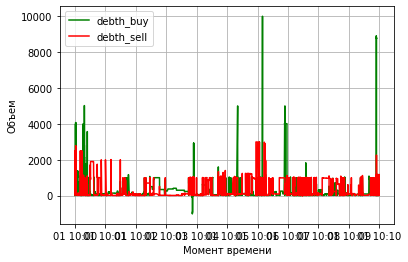

In [124]:
#Рисунок для глубины
fig, ax = plt.subplots()
plt.grid()
#plt.title('Динамика глубины')
plt.xlabel('Момент времени')
plt.ylabel('Объем')
ax.plot(df_results.time, df_results.depth_buy, color="green", label="debth_buy")
ax.plot(df_results.time, df_results.depth_sell, color="red", label="debth_sell")
ax.legend()
plt.show()

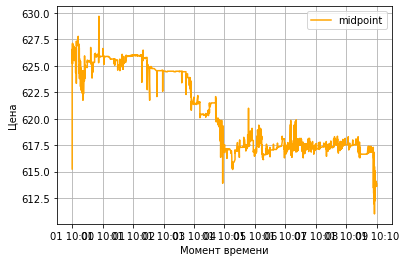

In [125]:
#Рисунок для мидпоинта
fig, ax = plt.subplots()
plt.grid()
#plt.title('Динамика мидпоинта')
plt.xlabel('Момент времени')
plt.ylabel('Цена')
ax.plot(df_results.time, df_results.midpoint, color="orange", label="midpoint")
ax.legend()
plt.show()

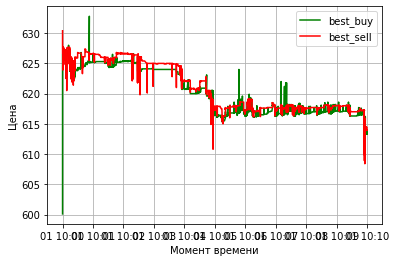

In [126]:
#Рисунок для лучших цен
fig, ax = plt.subplots()
plt.grid()
#plt.title('Динамика лучших цен')
plt.xlabel('Момент времени')
plt.ylabel('Цена')
ax.plot(df_results.time, df_results.best_buy, color="green", label="best_buy")
ax.plot(df_results.time, df_results.best_sell, color="red", label="best_sell")
ax.legend()
plt.show()

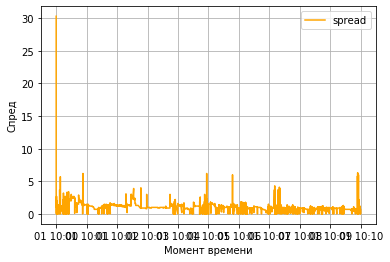

In [127]:
#Рисунок для спреда
fig, ax = plt.subplots()
plt.grid()
#plt.title('Динамика спреда')
plt.xlabel('Момент времени')
plt.ylabel('Спред')
ax.plot(df_results.time, df_results.bid_ask_spread, color="orange", label="spread")
ax.legend()
plt.show()

In [128]:
df_results.to_csv('nvtk_results.csv')
df_results.to_csv('nvtk_wait_list.csv')

In [146]:
nvtk_iceberg = df_wait_list.query('status == "iceberg"')

In [142]:
cum = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69]

In [147]:
nvtk_iceberg.insert(0,'cum',cum) 

In [152]:
nvtk_iceberg

,cum,buysell,place_time,orderno,price,volume,execution_time,cancel_time,status,execution_lag,iceberg_lag,cancel_lag
159,1,B,2015-09-01 10:00:00.739,9766,626.6,0,2015-09-01 10:00:00.896,2015-09-01,iceberg,0 days,00:00:00.157000,0 days
203,2,B,2015-09-01 10:00:01.723,11177,626.3,0,2015-09-01 10:00:01.726,2015-09-01,iceberg,0 days,00:00:00.003000,0 days
302,3,S,2015-09-01 10:00:08.376,18143,627.6,0,2015-09-01 10:00:10.882,2015-09-01,iceberg,0 days,00:00:02.506000,0 days
326,4,B,2015-09-01 10:00:11.576,22941,625.1,0,2015-09-01 10:00:14.230,2015-09-01,iceberg,0 days,00:00:02.654000,0 days
333,5,B,2015-09-01 10:00:11.865,23640,626.4,0,2015-09-01 10:00:13.790,2015-09-01,iceberg,0 days,00:00:01.925000,0 days
386,6,B,2015-09-01 10:00:14.231,26861,625.1,0,2015-09-01 10:00:14.268,2015-09-01,iceberg,0 days,00:00:00.037000,0 days
389,7,B,2015-09-01 10:00:14.272,26882,625.1,0,2015-09-01 10:00:14.307,2015-09-01,iceberg,0 days,00:00:00.035000,0 days
637,8,B,2015-09-01 10:00:16.334,28532,623.8,0,2015-09-01 10:00:16.372,2015-09-01,iceberg,0 days,00:00:00.038000,0 days
780,9,S,2015-09-01 10:00:22.317,34501,625.9,0,2015-09-01 10:00:24.428,2015-09-01,iceberg,0 days,00:00:02.111000,0 days
880,10,S,2015-09-01 10:00:27.464,39218,626.7,0,2015-09-01 10:00:29.735,2015-09-01,iceberg,0 days,00:00:02.271000,0 days


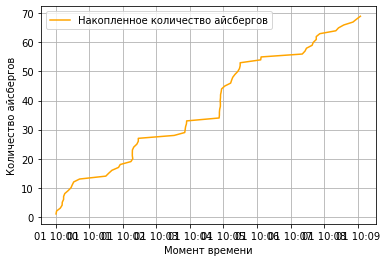

In [158]:
fig, ax = plt.subplots()
plt.grid()
#plt.title('Динамика спреда')
plt.xlabel('Момент времени')
plt.ylabel('Количество айсбергов')
ax.plot(nvtk_iceberg.place_time, nvtk_iceberg.cum, color="orange", label="Накопленное количество айсбергов")
ax.legend()
plt.show()

In [159]:
nvtk_iceberg.to_csv('nvtk_iceberg.csv')